### FAKE NEWS PREDICTION USING LSTM AND EMBEDDINGS

The motivation to use an Long Short Term Memory model was to evaluate how a deep learning model would do in terms of predicting fake news without performing too much data wrangling. The methodology used was to first get the data in a clean form that can be used to predict, then get word embeddings using Google's word2vec and finally using an LSTM neural network to train the model. Word embeddings are used so that the model can learn context of the sentences from past order of words in the text as well as the future order. LSTM is used to help the model learn from the linguistic context that has been developed progressively becasuse it capable of storing information for extended time periods. Therefore, the model levergaing LSTM is being tested to contrast the with supervised models which do not the context of previous inputs into account.

In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow import keras
from keras import regularizers, initializers, optimizers, callbacks
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import *
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

import pandas as pd
import numpy as np

import word2vec
import nltk
import gensim

2023-05-24 10:39:43.858666: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-24 10:39:44.065643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 10:39:45.024439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 10:39:45.027689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 10:39:48.775098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
df = pd.read_csv('all_preprocessed_data.csv')
df.head()

,Unnamed: 0,id,title,author,text,label,utterances,total_utterances,word_count,word_count_nltk,title_length,Length_bucket,author_bool,clean_text,clean_title,clean_authors,stem_text,stem_title,stem_lem_text,stem_lem_title
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,"By Darrell Lucus on October 30, 2016 Subscrib...",1,37.0,37,848,943,16,848,1,by darrell lucus on october thirty two thousan...,house dem aide we didn’t even see comey’s lett...,darrell lucus,"['darrel', 'lucu', 'octob', 'thirti', 'two', '...","['hous', 'dem', 'aid', '’', 'even', 'see', 'co...",darrel lucu octob thirti two thousand sixteen ...,hous dem aid ’ even see comey ’ letter jason c...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,32.0,29,706,822,8,706,1,ever get the feeling your life circles the rou...,flynn hillary clinton big woman on campus - br...,daniel j flynn,"['ever', 'get', 'feel', 'life', 'circl', 'roun...","['flynn', 'hillari', 'clinton', 'big', 'woman'...",ever get feel life circl roundabout rather hea...,flynn hillari clinton big woman campu - breitbart
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"October 29, 2016 \nThe tension between intell...",1,73.0,51,1271,1454,7,1271,1,october twenty-nine two thousand and sixteen t...,why the truth might get you fired,consortiumnewscom,"['octob', 'twenty-nin', 'two', 'thousand', 'si...","['truth', 'might', 'get', 'fire']",octob twenty-nin two thousand sixteen tension ...,truth might get fire
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos The rate at which civilians are being ...,1,28.0,27,562,612,10,562,1,videos the rate at which civilians are being k...,fifteen civilians killed in single us airstrik...,jessica purkiss,"['video', 'rate', 'civilian', 'kill', 'america...","['fifteen', 'civilian', 'kill', 'singl', 'us',...",video rate civilian kill american airstrik afg...,fifteen civilian kill singl u airstrik identifi
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,5.0,5,153,177,14,153,1,print an iranian woman has been sentenced to s...,iranian woman jailed for fictional unpublished...,howard portnoy,"['print', 'iranian', 'woman', 'sentenc', 'six'...","['iranian', 'woman', 'jail', 'fiction', 'unpub...",print iranian woman sentenc six year prison ir...,iranian woman jail fiction unpublish stori wom...


In [4]:
df['author_title_text'] = df['clean_authors'] + df['stem_lem_title'] + df['stem_lem_text']
df['author_title_text'].head()

0    darrell lucushous dem aid ’ even see comey ’ l...
1    daniel j flynnflynn hillari clinton big woman ...
2    consortiumnewscomtruth might get fireoctob twe...
3    jessica purkissfifteen civilian kill singl u a...
4    howard portnoyiranian woman jail fiction unpub...
Name: author_title_text, dtype: object

In [5]:
stop_words = set(stopwords.words('english'))

def stop_words_remove(data):
    '''
    Function to remove stop words. 

    Inputs:
        text (str): A string of text
    
    Outputs:
        processed text (str): A string of processed text
    '''
    
    # creating tokens
    data = nltk.word_tokenize(data)
    
    # remove stopwords
    data = [ele for ele in data if ele not in stop_words]

    data = ' '.join(data)
    
    return data

df['author_title_text'] = df['author_title_text'].astype(str).apply(stop_words_remove)

df['author_title_text'] = df['author_title_text'].astype(str).apply(lambda x: re.sub(r"[\’]+", "", x))
df['author_title_text'] = df['author_title_text'].astype(str).apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [6]:
#creating text variable and hot encoded label
x = df['author_title_text'].tolist()
y = pd.get_dummies(df['label'])
y = np.array(y)

In [7]:
#defining constants 
MAX_NB_WORDS = 1000000      # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000  # max length of each sentence, including padding
VALIDATION_SPLIT = 0.2      # 20% of data for validation 
EMBEDDING_DIM = 100          # embedding dimensions for word vectors

In [8]:
#tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index
print('Vocabulary size is:', len(word_index))

Vocabulary size is: 134471


In [9]:
# dictionary representation of each unique word in the data
print(word_index)

{'“': 1, '”': 2, 'said': 3, 'one': 4, 'two': 5, 'mr': 6, 'thousand': 7, 'trump': 8, 'hundr': 9, '—': 10, 'state': 11, 'would': 12, 'peopl': 13, 'new': 14, 'year': 15, 'like': 16, 'u': 17, 'time': 18, 'clinton': 19, 'presid': 20, 'also': 21, 'american': 22, 'say': 23, 'go': 24, 'nine': 25, 'even': 26, 'use': 27, 'make': 28, 'report': 29, 'work': 30, 'could': 31, 'mani': 32, 'nation': 33, 'govern': 34, 'get': 35, 'elect': 36, 'day': 37, 'four': 38, 'countri': 39, 'first': 40, 'call': 41, 'three': 42, 'unit': 43, 'twenty': 44, 'world': 45, 'take': 46, 'want': 47, 'last': 48, 'right': 49, 'polit': 50, 'obama': 51, 'news': 52, 'eight': 53, 'york': 54, 'hillari': 55, 'support': 56, 'six': 57, 'way': 58, 'includ': 59, 'campaign': 60, 'hous': 61, 'know': 62, 'come': 63, 'think': 64, 'back': 65, 'vote': 66, 'may': 67, '‘': 68, 'show': 69, 'seven': 70, 'offic': 71, 'democrat': 72, 'offici': 73, 'see': 74, 'war': 75, 'woman': 76, 'need': 77, 'white': 78, 'sixteen': 79, 'republican': 80, 'group': 

In [10]:
#padding
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Data tensor shape:', data.shape)
print('Label tensor shape:', y.shape)

Data tensor shape: (20166, 1000)
Label tensor shape: (20166, 2)


In [11]:
#random shuffling data and labels
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [12]:
# tokenized and padded data representation and hot encoded label
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 2712 95792    76  4794    68  1259  3284    14    54 42667    10  6420
  1223  5780   109  2189  2056  1284  1412   285    22   243   946    24
  1734  1251  1506   644  1532 12494  1812   644  2796    93  3356    62
   624  1720 11814    27     1   254    16    13    46  1655   793    46
  1655   720   694   138    23     4    96    89    16   216   611     2
     3  1223    44   333  2056   168   180   830  5178 32676    33    76
  4794  1476   107   284  1369  2056  3552   746   405  4794  1223  3567
   117   192   420   925   840     3     1  1259  3284  3908   152     2
  1223   117  1026   129   746  4309  1117  1121   150  2736   928   932
   231  3855  1556 10922   116  4065  3534   117   591  3770  1273   269
   480    89    14   925     1    24  2838    89  3051    74   141    74
   564     2  1223     3   363   311  1284  4794   765    31    63   417
 32676  2728   742   189  1314   708   878  1575  1007  4032   204    14
    54  9243  6595  1933   9

In [13]:
#splitting into train and validation data
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Entries in training set: ', y_train.sum(axis=0))
print('Entries in validation set: ', y_val.sum(axis=0))

Entries in training set:  [8285 7848]
Entries in validation set:  [2099 1934]


In [14]:
# Load Google news word2vec vectors
filename = '/home/ridhi/Documents/GoogleNews-vectors-negative300.bin'

# loading vectors
word2vec = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [15]:
EMBEDDING_DIM = 300

# get word index of Keras tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

emb_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in word2vec.key_to_index:
        emb_matrix[i] = word2vec.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(emb_matrix, axis=1) == 0))

Null word embeddings: 107271


In [16]:
#defining neural network with non-trainable embedding layer
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[emb_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

2023-05-24 10:52:43.746996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 10:52:43.748705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 10:52:43.750413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         40341600  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 40,586,146
Trainable params: 244,546
Non-trainable params: 40,341,600
_________________________________________________________________


Epoch 1/18


2023-05-24 10:54:34.954225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 10:54:34.956657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 10:54:34.958441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

127/127 [==============================] - ETA: 0s - loss: 0.6874 - acc: 0.5272

2023-05-24 10:58:18.444962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 10:58:18.447064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 10:58:18.448572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

127/127 [==============================] - 249s 2s/step - loss: 0.6874 - acc: 0.5272 - val_loss: 0.6712 - val_acc: 0.5393
Epoch 2/18
127/127 [==============================] - 238s 2s/step - loss: 0.6700 - acc: 0.5372 - val_loss: 0.6774 - val_acc: 0.5388
Epoch 3/18
127/127 [==============================] - 239s 2s/step - loss: 0.6664 - acc: 0.5397 - val_loss: 0.6656 - val_acc: 0.5418
Epoch 4/18
127/127 [==============================] - 247s 2s/step - loss: 0.6650 - acc: 0.5398 - val_loss: 0.6676 - val_acc: 0.5433
Epoch 5/18
127/127 [==============================] - 238s 2s/step - loss: 0.6827 - acc: 0.5413 - val_loss: 0.6922 - val_acc: 0.5247
Epoch 6/18
127/127 [==============================] - 237s 2s/step - loss: 0.6930 - acc: 0.5090 - val_loss: 0.6916 - val_acc: 0.5286
Epoch 7/18
127/127 [==============================] - 237s 2s/step - loss: 0.6918 - acc: 0.5142 - val_loss: 0.6897 - val_acc: 0.5331
Epoch 8/18
127/127 [==============================] - 239s 2s/step - loss: 0.689

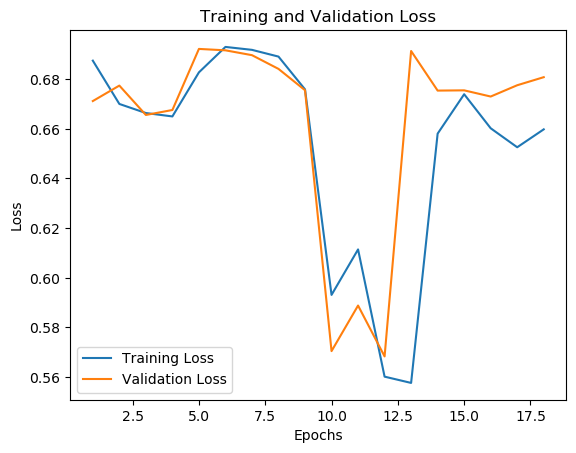

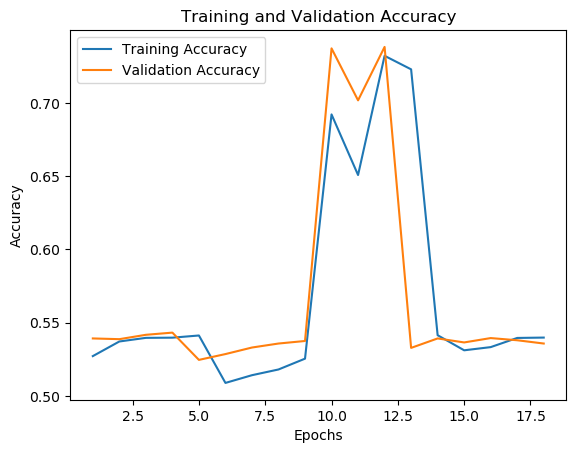

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

history = model.fit(x_train, y_train, epochs = 18, batch_size=128, validation_data=(x_val, y_val))
    
print(f"For number of epochs 18")

#Training and Validation loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();


#Training and Validation accuracy plot

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();